Generate synthetic dataset and look for correlations

In [1]:
import numpy
import nibabel
import os
import nilearn.plotting
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
import nipype.interfaces.fsl as fsl
import scipy.stats

%matplotlib inline
try:
    corrs
except:
    corrs={}

if 1:
    # this will recreate the example from the paper exactly
    seed=85077
else:
    seed=numpy.ceil(numpy.random.rand()*100000).astype('int')

numpy.random.seed(seed)

pthresh=0.005
cthresh=50

In [2]:
maskimg=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')
mask=nibabel.load(maskimg)
maskdata=mask.get_data()
maskvox=numpy.where(maskdata>0)
nsubs=24
data=numpy.zeros((maskdata.shape + (nsubs,)))
data2=numpy.zeros((maskdata.shape + (nsubs,)))
imgmean=1000

for i in range(nsubs):
    tmp=numpy.zeros(maskdata.shape)
    tmp[maskvox]=numpy.random.randn(len(maskvox[0]))*100+imgmean
    data[:,:,:,i]=tmp
    tmp[maskvox]=numpy.random.randn(len(maskvox[0]))*100+imgmean
    data2[:,:,:,i]=tmp

newimg=nibabel.Nifti1Image(data,mask.get_affine(),mask.get_header())
newimg.to_filename('fakedata.nii.gz')
regressor=numpy.random.randn(nsubs,1)+100
numpy.savetxt('regressor.txt',regressor)

# smooth data
smooth=fsl.IsotropicSmooth(fwhm=6,in_file='fakedata.nii.gz',out_file='fakedata_smooth.nii.gz')
smooth.run()


In [3]:
# run stats
glm = fsl.GLM(in_file='fakedata_smooth.nii.gz', 
              design='regressor.txt', 
              out_t_name='regressor_tstat.nii.gz',
             demean=True)
glm.run()

In [4]:
tcut=scipy.stats.t.ppf(1-pthresh,nsubs-1)
cl = fsl.Cluster()
cl.inputs.threshold = tcut
cl.inputs.in_file = 'regressor_tstat.nii.gz'
cl.inputs.out_index_file='tstat_cluster_index.nii.gz'
results=cl.run()

In [5]:
clusterimg=nibabel.load(cl.inputs.out_index_file)
clusterdata=clusterimg.get_data()
indices=numpy.unique(clusterdata)


[[ 1.          0.84329273]
 [ 0.84329273  1.        ]]


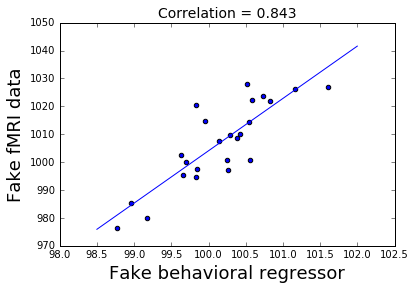

In [25]:
clustersize=numpy.zeros(len(indices))
clustermean=numpy.zeros((len(indices),nsubs))
for c in range(1,len(indices)):
    indvox=numpy.where(clusterdata==c)    
    clustersize[c]=len(indvox[0])
    for i in range(nsubs):
        tmp=data[:,:,:,i]
        clustermean[c,i]=numpy.mean(tmp[indvox])
corrs[seed]=numpy.corrcoef(regressor.T,clustermean[-1])
print(corrs[seed])
plt.scatter(regressor.T,clustermean[-1])
plt.title('Correlation = %0.3f'%corrs[seed][0,1],fontsize=14)
plt.xlabel('Fake behavioral regressor',fontsize=18)
plt.ylabel('Fake fMRI data',fontsize=18)
m, b = numpy.polyfit(regressor[:,0], clustermean[-1], 1)
axes = plt.gca()
X_plot = numpy.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')
plt.savefig('scatter.png',dpi=600)



In [7]:
# make thresholded stats image
tstat=nibabel.load('regressor_tstat.nii.gz').get_data()
thresh_t=clusterdata.copy()
cutoff=numpy.min(numpy.where(clustersize>cthresh))
thresh_t[thresh_t<cutoff]=0
thresh_t=thresh_t*tstat
thresh_t_img=nibabel.Nifti1Image(thresh_t,mask.get_affine(),mask.get_header())

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


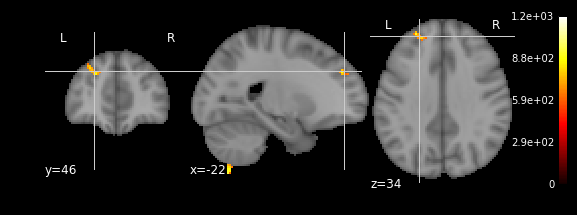

In [8]:
mid=len(indvox[0])/2
coords=numpy.array([indvox[0][mid],indvox[1][mid],indvox[2][mid],1]).T
mni=mask.get_qform().dot(coords)
nilearn.plotting.plot_stat_map(thresh_t_img,
        os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                              threshold=cl.inputs.threshold,
                               cut_coords=mni[:3])
plt.savefig('slices.png',dpi=600)

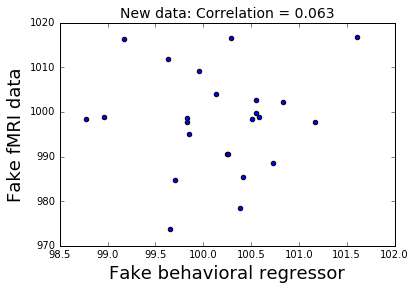

In [9]:
# Now examine fit to another dataset
newdata_clustermean=numpy.zeros(nsubs)
for i in range(nsubs):
    tmp=data2[:,:,:,i]
    newdata_clustermean[i]=numpy.mean(tmp[indvox])

plt.scatter(regressor.T,newdata_clustermean)
plt.title('New data: Correlation = %0.3f'%numpy.corrcoef(regressor.T,newdata_clustermean)[0,1],fontsize=14)
plt.xlabel('Fake behavioral regressor',fontsize=18)
plt.ylabel('Fake fMRI data',fontsize=18)
plt.savefig('scatter_newdata.png')

In [10]:
from sklearn import cross_validation
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression

def get_sample_balcv(x,y,nfolds,pthresh=0.8):
    """
    This function uses anova across CV folds to find
    a set of folds that are balanced in their distriutions
    of the X value - see Kohavi, 1995
    """

    nsubs=len(x)

    # cycle through until we find a split that is good enough
    
    good_split=0
    while good_split==0:
        cv=cross_validation.KFold(n=nsubs,n_folds=nfolds,shuffle=True)
        ctr=0
        idx=numpy.zeros((nsubs,nfolds)) # this is the design matrix
        for train,test in cv:
            idx[test,ctr]=1
            ctr+=1

        lm_x=OLS(x-numpy.mean(x),idx).fit()
        lm_y=OLS(y-numpy.mean(y),idx).fit()

        if lm_x.f_pvalue>pthresh and lm_y.f_pvalue>pthresh:
            good_split=1

    # do some reshaping needed for the sklearn linear regression function
    x=x.reshape((nsubs,1))
    y=y.reshape((nsubs,1))
    
    pred=numpy.zeros((nsubs,1))
    
    for train,test in cv:
        lr=LinearRegression()
        lr.fit(x[train,:],y[train,:])
        pred[test]=lr.predict(x[test])

    return numpy.corrcoef(pred[:,0],y[:,0])[0,1],pred


In [11]:
c,pred=get_sample_balcv(regressor,clustermean[-1,:].T,4)

/Users/poldrack/anaconda/envs/py3k/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


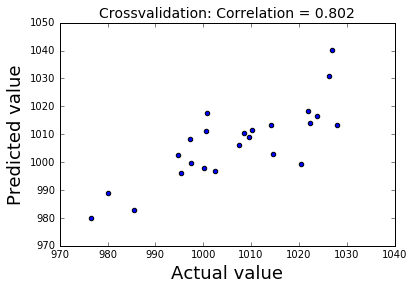

In [12]:
plt.scatter(clustermean[-1,:],pred)
plt.title('Crossvalidation: Correlation = %0.3f'%c,fontsize=14)
plt.xlabel('Actual value',fontsize=18)
plt.ylabel('Predicted value',fontsize=18)
plt.savefig('scatter_cv.png')